In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#!pip install sort-dataframeby-monthorweek
#!pip install sorted-months-weekdays

# 1. Initial Data Cleaning

Our data set is from Kaggle and fairly large, with over 100,000 rows and 32 columns. Each row is a different reservation. Our target variable is whether or not they ended up cancelling their reservation. Our classes are imbalanced towards non cancelations but not to a huge extent (75,000 - 45,000). This may affect a logistic regression, but a more powerful model with this much data will be fine.

In [16]:
#reading in the data and increasing the number of rows and columns pandas will display
df = pd.read_csv("data/hotel_bookings.csv")
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 200

In [17]:
#119,390 rows, 32 columns
df.shape

(119390, 32)

In [18]:
#our two classes 0 = did not cancel and 1 = did 
df.is_canceled.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

These are variables from after someone has checked in so they are not suitable for a predictive model. 

In [19]:
#dropping these columns
df = df.drop('reservation_status', axis = 1)

In [20]:
df = df.drop('reservation_status_date', axis = 1)

There is exactly one family with 10 children, the rest have 3 or less, lets just get rid of that outlier.

In [75]:
#checking the value counts for the children and realizing the outlier 
df.children.value_counts()


0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [76]:
df.children = df[df.children < 10]

We do not need the precision that day of the month or the week number provides to make a generalizable model 

In [77]:
#dropping week and day data 
df = df.drop('arrival_date_week_number', axis = 1)
df = df.drop('arrival_date_day_of_month', axis =1)

There are over 200 countries where people are visiting from in this data set, that will be a nightmare to make dummy variables out of and train models on, and may overfit to countries with few visitors, lets narrow it down to the top 20 and have the rest be "other".

In [78]:
#creating a column then using groupby to sum all the values in that column and sort the data
df['one'] = 1
top_20_countries = df.groupby('country').sum().sort_values('one', ascending = False)[:20].index
df['top_20_c'] = df.country.apply(lambda x: x in top_20_countries)
df['country'] = np.where(df.top_20_c == True, df.country, 'other')

In [79]:
#using value counts to see if it worked
df.country.value_counts()

PRT      48590
GBR      12129
FRA      10415
ESP       8568
other     7371
DEU       7287
ITA       3766
IRL       3375
BEL       2342
BRA       2224
NLD       2104
USA       2097
CHE       1730
CN        1279
AUT       1263
SWE       1024
CHN        999
POL        919
ISR        669
RUS        632
NOR        607
Name: country, dtype: int64

In [80]:
#getting rid of an extraneous column we used to filter the data 
df = df.drop('top_20_c', axis = 1)

Lets do a similar thing to company as we did for countries but only the top 10. companies with only a few reservations do not seem very predictive and could over fit the model. We will also set the NaNs (the majority of the dataset) to "no company."

In [81]:
#turning all the values into string 
df['company'] = df.company.astype(str)

In [82]:
#making 'nan' into no company using np.where
df['company'] = np.where(df.company == 'nan', 'no_company', df.company)

In [83]:
#using a similar plan as the country data to get the companies that booked the most reservations 
top_11_companies = df.groupby('company').sum().sort_values('one', ascending = False)[:11].index
df['top_10_co'] = df.company.apply(lambda x: x in top_11_companies)


In [84]:
#and making the column using our earlier work as a filter with np.where 
df['company'] = np.where(df.top_10_co == True, df.company, 'other')

In [85]:
#using value count to make sure it worked 
df.company.value_counts()

no_company    112593
other           3674
40.0             927
223.0            784
67.0             267
45.0             250
153.0            215
174.0            149
219.0            141
281.0            138
154.0            133
405.0            119
Name: company, dtype: int64

In [86]:
#dropping some columns we used to tabulate the data 
df = df.drop('one', axis = 1)

In [87]:
df = df.drop('top_10_co', axis = 1)

Theres some pesky nans floating around.

In [88]:
#checking which columns they are in 
df.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              5
babies                                0
meal                                  0
country                               0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             16340
company                               0
days_in_waiting_list                  0
customer_type                         0


In [89]:
#converting booking with travel agent to a dummy variable 
df['agent'] = np.where((df['agent'].astype('str') == 'NaN')|(df['agent'].astype('str') == 'nan'), 0, 1)

Not so pesky after all, they showed us we could make the travel agent column a dummy variable between people who did and did not have an agent.

# 2. Exploratory Data Analysis

In [21]:
# Font for the visual aids
sub = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
Title = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }

Lets figure out how much money our hotels lost on cancellations.

In [91]:
#combining the weekend nights and weekday nights to get the total length of the reservation 
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [92]:
#using this data to calculate how much the hotel lost during this time period 
(df[df.is_canceled == 1]['total_nights'] * df[df.is_canceled == 1]['adr']).sum()

16727237.120000001

16.7 million in three years! Thats a lot of cash! At the end we will show how much of this our model could save. This does not calculate the labor involved in switching reservations around and/or preparing different rooms. 

In [93]:
#checking the mean of the average daily rate of the city hotel
df[df.hotel == 'City Hotel']['adr'].mean()

105.30446539770578

In [94]:
#and the mean of the country hotel 
df[df.hotel == 'Resort Hotel']['adr'].mean()

94.9529296055916

In [95]:
#checking how many reservations each hotel had 
df["hotel"].value_counts() 

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

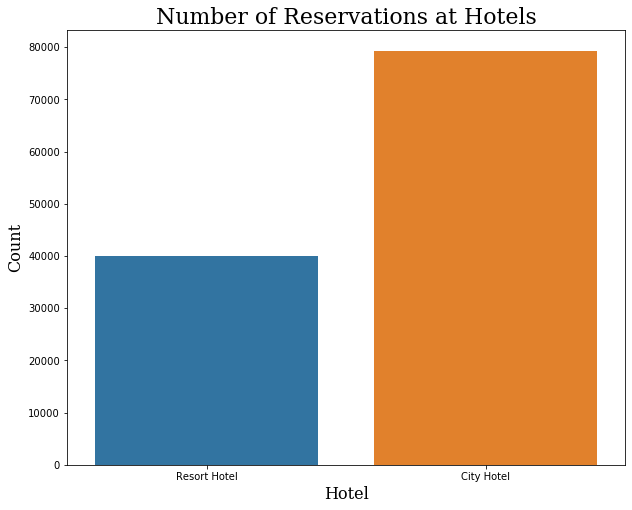

In [96]:
#making a bar graph to display this data and implememnting custom titles and fonts 
fig, ax = plt.subplots(figsize = (10,8))
ax=sns.countplot(x='hotel', data = df)
plt.title('Number of Reservations at Hotels', fontdict = Title)
plt.xlabel('Hotel', fontdict = sub)
plt.ylabel('Count', fontdict = sub)
plt.savefig('images/total_reservations', bbox_inches = "tight");

Unsurprisingly, the city hotel in our dataset had far more reservations.

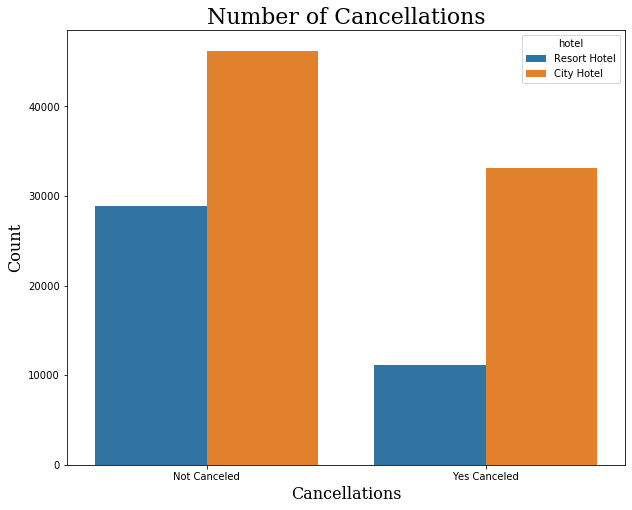

In [97]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.countplot(x='is_canceled', data = df, hue= "hotel")
plt.title('Number of Cancellations', fontdict = Title)

plt.xlabel('Cancellations', fontdict =  sub)
plt.ylabel('Count',  fontdict = sub);
plt.xticks([0,1],["Not Canceled", "Yes Canceled"])
plt.savefig('images/total_cancel', bbox_inches = "tight");


Cancelations make up almost 40% of total reservations.

In [98]:
df.groupby(['hotel', 'arrival_date_year'])['is_canceled'].sum() #number of cancellations per year for each hotel

hotel         arrival_date_year
City Hotel    2015                  6004
              2016                 15407
              2017                 11691
Resort Hotel  2015                  2138
              2016                  4930
              2017                  4054
Name: is_canceled, dtype: int64

''

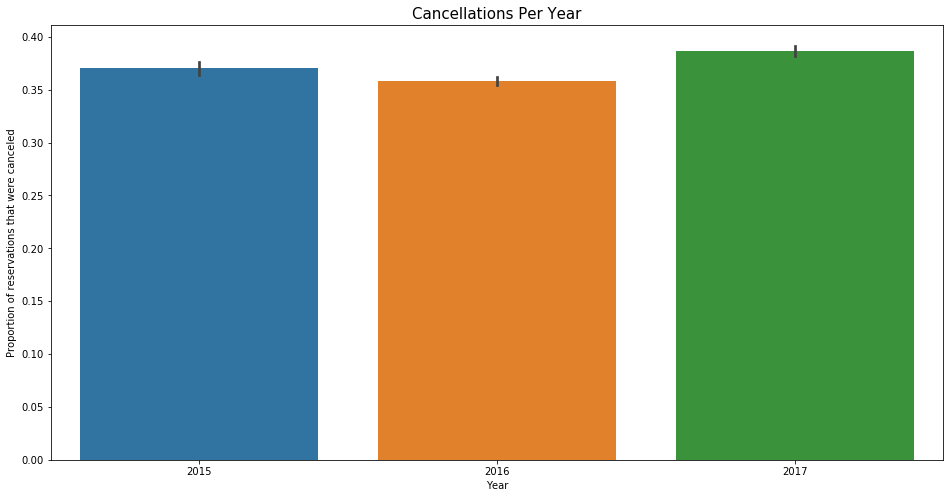

In [99]:
fig2, axes = plt.subplots( figsize = (16, 8))
sns.barplot(x = 'arrival_date_year', y = df['is_canceled'], data = df,)
plt.title('Cancellations Per Year', size = 15)
plt.xlabel('Year')
plt.ylabel('Proportion of reservations that were canceled')
;

The proportion of cancellations has not changed much in the past 3 years.

In [100]:
import datetime
import sort_dataframeby_monthorweek
df_sort = sort_dataframeby_monthorweek.Sort_Dataframeby_Month(df=df,monthcolumnname='arrival_date_month')
df_X = df_sort.groupby('hotel')['arrival_date_month'].count().plot


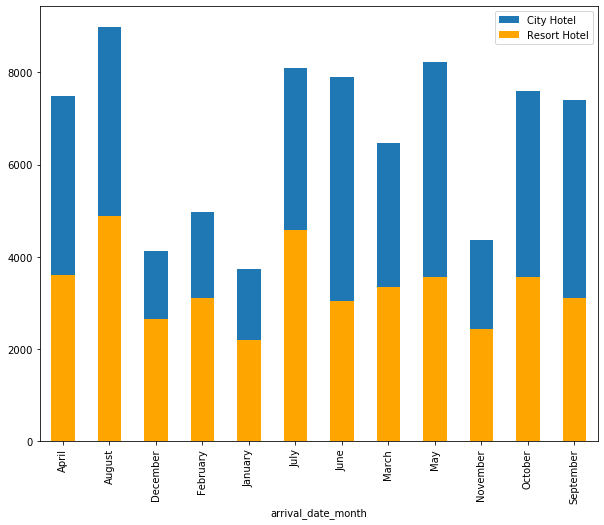

In [124]:
fig, ax = plt.subplots(figsize = (10,8))
df_sort[df_sort.hotel == 'City Hotel'].groupby('arrival_date_month')['hotel'].count().plot(kind = 'bar', ax = ax)
df_sort[df_sort.hotel == 'Resort Hotel'].groupby('arrival_date_month')['hotel'].count().plot(kind = 'bar', ax = ax, color = 'orange') 
plt.legend(labels = ['City Hotel', 'Resort Hotel'])

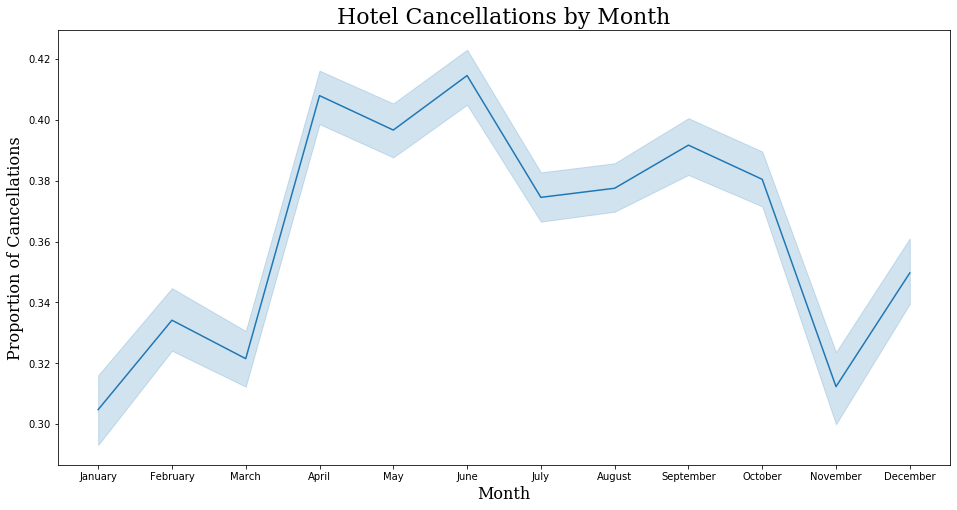

In [122]:
#df.groupby(['arrival_date_month'])['is_canceled'].sum().plot.bar(figsize=(12,8)) # plotting the above information
fig2, axes = plt.subplots( figsize = (16, 8))
sns.lineplot(x = 'arrival_date_month', y = 'is_canceled', sort = False, data = df_sort)
#sns.lineplt(x = 'arrival_date_month', y =)
plt.title('Hotel Cancellations by Month', fontdict = Title)
plt.ylabel('Proportion of Cancellations', fontdict = sub)
plt.xlabel("Month", rotation = 0, fontdict=sub)
plt.xticks(rotation=0)
plt.savefig('images/cancellation_months', bbox_inches = "tight");


People are less likely to cancel in the winter months. Even though reservations in the winter months are down as whole, there is still a sizeable difference in proportion of reservations that get cancelled when comparing the two graphs. 

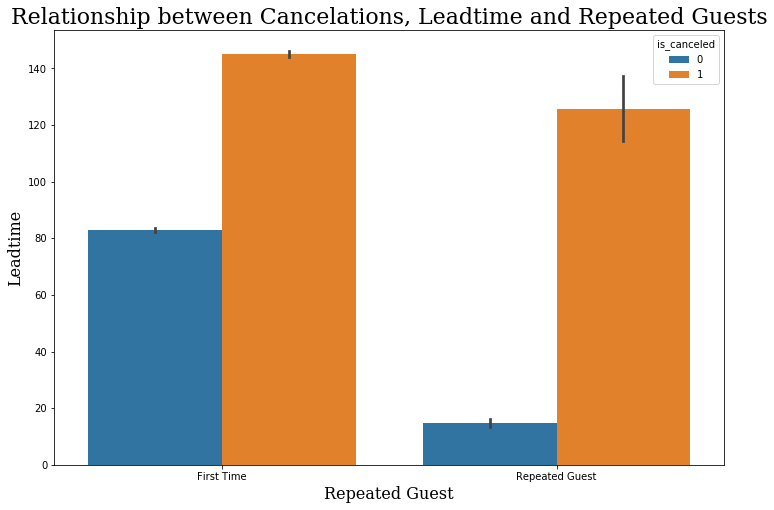

In [33]:
fig, ax = (plt.subplots(figsize = (12,8)))
sns.barplot(x="is_repeated_guest",y= "lead_time", data=df, hue="is_canceled")
plt.title("Relationship between Cancelations, Leadtime and Repeated Guests", fontdict = Title)
plt.xlabel("Repeated Guest", fontdict = sub)
plt.ylabel("Leadtime", fontdict = sub)
plt.xticks([0,1],['First Time', 'Repeated Guest'])
#plt.legend(["No", "Yes"])
plt.savefig('images/relationship_cancel_lt_repeated', bbox_inches = "tight");

Overall, longer lead times lead to more cancellations but interestingly this affect is amplified for repeat guests.

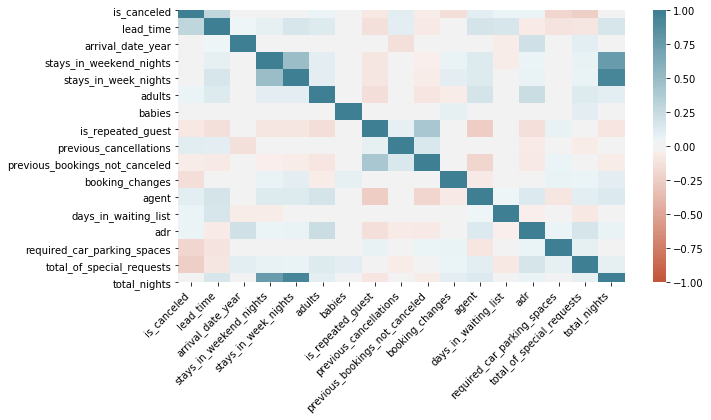

In [203]:
# correlation polt to check for exisiting colinearity that should be taken into consideration
# for feature engineering and feature selection
corr = df.corr()

plt.figure(figsize = (10, 5))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, 
                 cmap = sns.diverging_palette(20, 220, n = 200))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right');


# 3. Feature Engineering 

Lets add a feature where somebody got a different room type than the one they reserved, as this may make them likely to cancel.

In [204]:
df['dif_room_than_res'] = np.where(df.reserved_room_type == df.assigned_room_type, 0, 1)

Most people were not put on the waiting list at all. Lets just change it to more of a had to wair or did not have to wait column. 

In [205]:
df['had_to_wait'] = np.where(df['days_in_waiting_list']>0, 1, 0)
df = df.drop('days_in_waiting_list', axis = 1)

This feature might have colinearity issues BUT we will probably settle on a complex model that adresses this and it will help evualate the precision profit trade off I will get into later. 

In [206]:
df['total_cost'] = df.adr * df.total_nights 

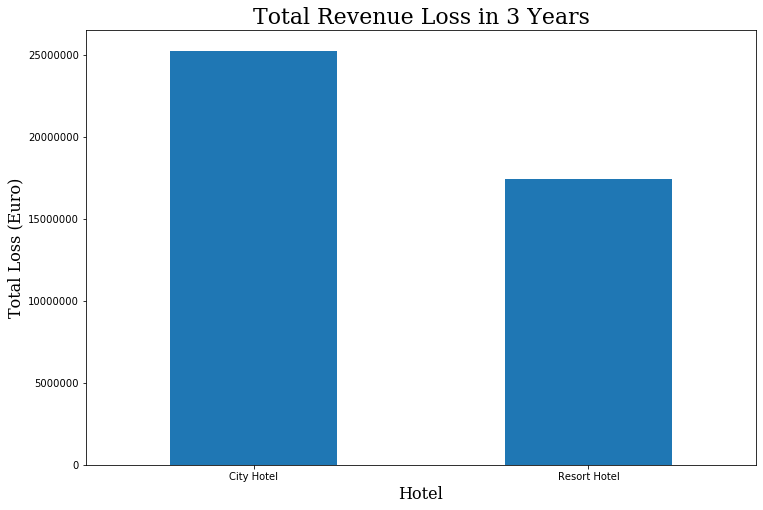

In [207]:
fig, ax = (plt.subplots(figsize = (12,8)))
df.groupby(['hotel'])['total_cost'].sum().plot(kind="bar")
plt.title('Total Revenue Loss in 3 Years', fontdict = Title)
plt.ylabel('Total Loss (Euro)', fontdict = sub)
plt.xlabel("Hotel", rotation = 0, fontdict=sub)
plt.xticks(rotation=0)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig('images/total_Revenue_Loss', bbox_inches = "tight");

In [208]:
df.groupby(['hotel'])['total_cost'].sum()

hotel
City Hotel      25279469.96
Resort Hotel    17444027.57
Name: total_cost, dtype: float64

In [144]:
df.groupby(['hotel'])['adr','total_nights'].mean()

/Users/DataSci/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,adr,total_nights
hotel,,
City Hotel,105.304465,2.978142
Resort Hotel,94.952930,4.318547


Now lets make dummy variable out of the bevy of categorical data to make our data suited for any kind of model we choose to run.

In [145]:
df = pd.get_dummies(df, columns = ['deposit_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['customer_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['arrival_date_month'], drop_first = True)
df = pd.get_dummies(df, columns = ['reserved_room_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['assigned_room_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['meal'], drop_first = True)
df = pd.get_dummies(df, columns = ['market_segment'], drop_first = True)
df = pd.get_dummies(df, columns = ['country'], drop_first = True)
df = pd.get_dummies(df, columns = ['distribution_channel'], drop_first = True)
df = pd.get_dummies(df, columns = ['children'], drop_first = True)
df = pd.get_dummies(df, columns = ['hotel'], drop_first = True)
df = pd.get_dummies(df, columns = ['company'], drop_first = True)



Now that we can see the relationships between the features and have made dummy columns for the categorical features, we will test what the base model looks like right now and improve the model to make better predictions. 

In [146]:
from sklearn.linear_model import LogisticRegression # Import Logistic Regression
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import make_scorer, accuracy_score #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, classification_report

#### Logistic Regresion Base model

In [147]:
X = df.drop('is_canceled', axis =1)
y = df.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [148]:
lr = LogisticRegression (max_iter = 2000)
lr.fit(X_train, y_train)
base_lr_test_pred = lr.predict(X_test)


In [149]:

print("Precision Score: ", precision_score(y_test, base_lr_test_pred))
print ("Confusion Matrix: ", metrics.confusion_matrix(y_test, base_lr_test_pred))
print("Classification Report: ", classification_report(y_test, base_lr_test_pred))

Precision Score:  0.8131534569983137
Confusion Matrix:  [[17191  1662]
 [ 3762  7233]]
Classification Report:                precision    recall  f1-score   support

           0       0.82      0.91      0.86     18853
           1       0.81      0.66      0.73     10995

    accuracy                           0.82     29848
   macro avg       0.82      0.78      0.80     29848
weighted avg       0.82      0.82      0.81     29848



# 4. Model iterations

Since overbooking a room where someone did not cancel would be a headache, we tailored our models towards precision. AKA if we say someone is going to cancel, there is a very high chance they are. This might dip into profitabality since less rooms can be overbooked but that could be adjusted on a client by client basis. 

### Test Train Split

In [150]:
X = df.drop('is_canceled', axis =1)
y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


### Scaling our data

In [151]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)


### Logistic Regression

In [152]:
lr = LogisticRegression (max_iter = 1000)
lr.fit(scaled, y_train)
lr_test_pred = lr.predict(scaled_test)


In [153]:
metrics.precision_score(y_test , lr_test_pred)

0.8082913165266107

In [154]:
print("Precision Score: ")
print(precision_score(y_test, lr_test_pred))
print ("Confusion Matrix: ",)
print(metrics.confusion_matrix(y_test, lr_test_pred))
print("Classification Report: ",)
print(classification_report(y_test, lr_test_pred))

Precision Score: 
0.8082913165266107
Confusion Matrix: 
[[17142  1711]
 [ 3781  7214]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     18853
           1       0.81      0.66      0.72     10995

    accuracy                           0.82     29848
   macro avg       0.81      0.78      0.79     29848
weighted avg       0.82      0.82      0.81     29848



### With Ridge

In [155]:
lr = LogisticRegression (penalty = 'l1', solver='saga', max_iter = 1000)
lr.fit(scaled, y_train)
ridge_test_pred = lr.predict(scaled_test)

In [156]:
metrics.precision_score(y_test, ridge_test_pred)
print("Precision Score: ")
print(precision_score(y_test, ridge_test_pred))
print ("Confusion Matrix: ",)
print(metrics.confusion_matrix(y_test, ridge_test_pred))
print("Classification Report: ",)
print(classification_report(y_test, ridge_test_pred))

Precision Score: 
0.8121131741821397
Confusion Matrix: 
[[17153  1700]
 [ 3647  7348]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     18853
           1       0.81      0.67      0.73     10995

    accuracy                           0.82     29848
   macro avg       0.82      0.79      0.80     29848
weighted avg       0.82      0.82      0.82     29848



### Random Forest Model

Our initial results with this model looked promising so we ran a grid search to find the best hyper paramaters.

In [157]:
rfc = RandomForestClassifier(random_state = 1, n_estimators=300, max_depth=10, max_features='auto')

In [158]:
rfc = rfc.fit(X_train, y_train)

In [159]:
rfc_test_pred = rfc.predict(X_test)
metrics.precision_score(y_test, rfc_test_pred)

0.8921568627450981

In [160]:
print("Precision Score: ")
print(precision_score(y_test, rfc_test_pred))
print ("Confusion Matrix: ",)
print(metrics.confusion_matrix(y_test, rfc_test_pred))
print("Classification Report: ",)
print(classification_report(y_test, rfc_test_pred))

Precision Score: 
0.8921568627450981
Confusion Matrix: 
[[17973   880]
 [ 3715  7280]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     18853
           1       0.89      0.66      0.76     10995

    accuracy                           0.85     29848
   macro avg       0.86      0.81      0.82     29848
weighted avg       0.85      0.85      0.84     29848



### With Gridsearch recommended Hyper Paramaters 

I ran a grid search in a different notebook and simply did not have time to replicate that here, it is in aidans notebook gridsearch, I chose the hyper parameters it liked best and input them into the model with a max depth of only 2 here. Seemingly a random "stump" style model worked best to increase precision.  

In [161]:
rfc = RandomForestClassifier(random_state = 1, n_estimators=300, max_depth=2, max_features='auto')

In [162]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=300, random_state=1)

In [163]:
rfc_preds = rfc.predict(X_test)

In [164]:
print("Precision Score: ")
print(metrics.precision_score(y_test, rfc_preds))
print ("Confusion Matrix: ",)
print(metrics.confusion_matrix(y_test, rfc_preds))
print("Classification Report: ",)
print(classification_report(y_test, rfc_preds))

Precision Score: 
0.9992117708880714
Confusion Matrix: 
[[18850     3]
 [ 7192  3803]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     18853
           1       1.00      0.35      0.51     10995

    accuracy                           0.76     29848
   macro avg       0.86      0.67      0.68     29848
weighted avg       0.83      0.76      0.72     29848



### XGBoost with GBTree

While the Random Forest model pretty much maxed out precision, it was lacking in the other measures, can we create something more balanced?

In [165]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 10, 
                           alpha = 1, 
                           n_estimators = 1000,
                           verbosity = 1,
                           booster = 'gbtree',
                          )

In [166]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, colsample_bytree=0.5, max_depth=10, n_estimators=1000,
              subsample=0.5)

In [167]:
xg_preds2 = xg_clf.predict(X_test)

In [168]:
print("Precision Score: ")
print(metrics.precision_score(y_test, xg_preds2))
print ("Confusion Matrix: ",)
print(metrics.confusion_matrix(y_test, xg_preds2))
print("Classification Report: ",)
print(classification_report(y_test, xg_preds2))

Precision Score: 
0.8573865251587226
Confusion Matrix: 
[[17348  1505]
 [ 1947  9048]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     18853
           1       0.86      0.82      0.84     10995

    accuracy                           0.88     29848
   macro avg       0.88      0.87      0.87     29848
weighted avg       0.88      0.88      0.88     29848



# 6. Model Interpretation 

Predicting hotel reservations has a precision-profit tradeoff, where a model tailored totally towards precision is middling or bad in other metrics. If a hotel prefers maximum precision to avoid any booking conflicts or orginazational headaches they lose profit by not correctly predicting many actual cancellations. Therefore we reccomend the xg boost model as it is more well rounded and still has a strong precision score. 